# MATH 405/607 

# Numerical Methods for Differential Equations

[[Instructor: Christoph Ortner]](http://www.math.ubc.ca/~ortner/)  [[CANVAS]](https://canvas.ubc.ca/courses/55324)


## PDEs - Advection

* The advection equation (transport)
* characteristics 
* upwind scheme, downwind scheme
* CFL condition 
* numerical dissipation and dispersion
* Lax-Wendroff scheme 
* Conservation laws 

### Literature

* Morton and Mayers: Numerical Solution of Partial Differential Equations

In [1]:
include("../math405.jl")

 Activating environment at `~/Documents/UBC/Math/Math 405/math405_2020W/Project.toml`


### Motivation 

* Conservation laws 
$$ 
    {\bf u}_t + \big({\bf f}(x, {\bf u})\big)_x = 0 
$$

* Wave equation 
$$ 
    u_{tt} = u_{xx}
$$
or equivalently 
$$ 
    u_t = v_x, \qquad v_t = u_x
$$

* Advection-diffusion 
$$ 
    u_t = a u_x + c u_{xx}
$$
(closely connected to Fokker-Planck, Black-Scholes, Navier-Stokes)

### Model Problem 

$$\begin{aligned} 
    u_t(x, t) + a u_x(x,t) &= 0, \qquad x \in \mathbb{R}, \quad t > 0, \\ 
                    u(x, 0) &= u_0(x)
\end{aligned}$$
where $a$ is constant. This can be solved by the method of characteristics, 
$$
    \frac{d}{dt} u(x_0 + at, t) = u_t + a u_x = 0,
$$
i.e. $u$ is constant along the *characteristics* $(x_0 + a t, t)$: 
$$
    u(x, t) = u_0(x - at)
$$

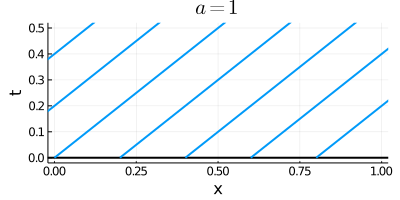

In [2]:
MATH405.illustrate_characteristicsR()

If $u_0$ is 1-periodic, then solving on $x \in \mathbb{R}$ is equivalent to solving on $x \in (0, 1]$ with periodic boundary conditins (PBCs): 

$$\begin{aligned}
    u_t(x, t) + a u_x(x,t) &= 0, \qquad x \in (0, 1), \quad t > 0, \\ 
                    u(x, 0) &= u_0(x), \\ 
                    u(0, t) &= u(1, t)
\end{aligned}$$

After rescaling time we can always set $a = 1$, let's keep this for now!

Discretise in space: $U_n(t) \approx u(nh, t)$. 

* How should we discretise $u_x$? 
    - Forward difference: $u_x(x_n) \approx (U_{n+1} - U_n) / h$? 
    - Backward difference: $u_x(x_n) \approx (U_{n} - U_{n-1}) / h$? 

Discretise in time as well: $U_n^k(t) \approx U_n(k\tau) \approx u(nh, k\tau)$

The space discretisation is first-order so let's just use the forward Euler method to discretise in time and we can explore issues such as stiffness, and higher-order schemes later. This gives us two possible schemes: 

$$
    \frac{U_n^{m+1} - U_n^m}{\tau} + \frac{U_{n+1}^m - U_n^m}{h} = 0
    \qquad \text{and} \qquad 
    \frac{U_n^{m+1} - U_n^m}{\tau} + \frac{U_{n}^m - U_{n-1}^m}{h} = 0
$$

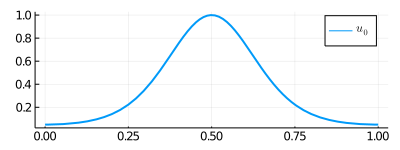

In [3]:
N = 50; h = 1/N
X = range(h, 1, length=N)
Id = sparse(I, (N, N))
D⁺ = (circshift(Id, -1) - Id) / h
D⁻ = (Id - circshift(Id, 1)) / h
u0 = x -> exp( - 3 * cos(pi*x)^2 )
plot(u0, 0, 1, lw=2, size = (400, 150), label = L"u_0")

┌ Info: Saved animation to 
│   fn = /Users/owensheekey/Documents/UBC/Math/Math 405/math405_2020W/notes/tmp.gif
└ @ Plots /Users/owensheekey/.julia/packages/Plots/shY1Z/src/animation.jl:104


Plots.AnimatedGif("/Users/owensheekey/Documents/UBC/Math/Math 405/math405_2020W/notes/tmp.gif")
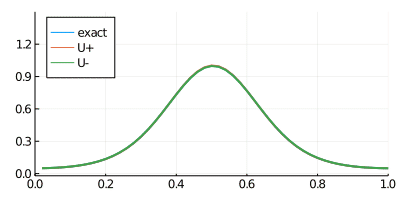

In [4]:
τ = 0.2 * h # let's be a bit conservative here!
U⁺ = u0.(X); U⁻ = u0.(X);
@gif for m = 1:150
    U⁺ -= τ * (D⁺ * U⁺)
    U⁻ -= τ * (D⁻ * U⁻)
    plot(X, u0.(X .- m*τ), lw=2, size = (400, 200), xlims = (0, 1), ylims = (-0.02, 1.5), label = "exact", legend = :topleft)
    plot!(X, U⁺, lw=2, label = "U+")
    plot!(X, U⁻, lw=2, label = "U-")
end

### Upwind and Downwind

Advection model problem: assume $a > 0$
$$\begin{aligned}
    u_t(x, t) + a u_x(x,t) &= 0, \qquad x \in \mathbb{R}, \quad t > 0, \\ 
                    u(x, 0) &= u_0(x), \\ 
\end{aligned}$$

Two discretisations: 
$$
    \frac{U_n^{m+1} - U_n^m}{\tau} + a \frac{U_{n+1}^m - U_n^m}{\tau} = 0
    \qquad \text{and} \qquad 
    \frac{U_n^{m+1} - U_n^m}{\tau} + a \frac{U_{n}^m - U_{n-1}^m}{\tau} = 0
$$

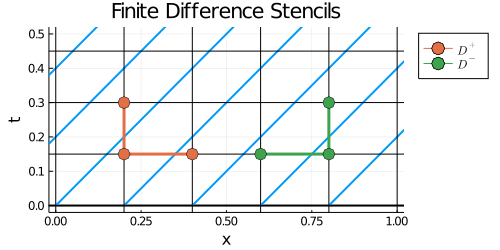

In [5]:
MATH405.illustrate_fwdbwdstencils() # maybe this gives us a hint???

### Analysis of the upwind scheme (backward difference)

same old strategy ... $u_n^m := u(nh, m\tau)$ then 
$$\begin{aligned}
    \frac{u_n^{m+1} - u_n^m}{\tau} + a \frac{u_n^m - u_{n-1}^m}{h} &= T_n^m, \\ 
    \frac{U_n^{m+1} - U_n^m}{\tau} + a \frac{U_n^m - U_{n-1}^m}{h} &= 0, \\ 
\end{aligned}$$

with $|T_n^m| \leq C(h + \tau)$. (easy exercise by now ...)

$E_n^m := u_n^m - U_n^m$, then 
$$ 
    \frac{E_n^{m+1} - E_n^m}{\tau} + a \frac{E_n^m - E_{n-1}^m}{h} = T_n^m
$$
or, equivalently, with $\mu = a \tau/h$, 
$$ 
    E_n^{m+1} = (1 - \mu) E_n^m + \mu E_{n-1}^m + \tau T_n^m
$$

With $\mu = a \tau/h$, 
$$ 
    E_n^{m+1} = (1 - \mu) E_n^m + \mu E_{n-1}^m + \tau T_n^m
$$

If $a > 0$ then $\mu > 0$. If in addition we assume that $\mu \leq 1$, then 
$$\begin{aligned}
    |E_n^{m+1}| 
    &\leq (1-\mu) \|E^m\|_\infty + \mu \|E^m\|_\infty + \tau \|T^m\|_\infty \\ 
   \|E^{m+1}\|_\infty &\leq \|E^m\|_\infty +  \tau \|T^m\|_\infty,
\end{aligned}$$

I.e., the upwind scheme is stable! We can now proceed as in previous lectures...

**Theorem:** Provided that $|a| \tau \leq h$, the *upwind scheme* is first-order accurate and convergent, 

$$
    \max_{x_n, t_k \leq T_f} |u(x_n, t_k) - U_n^k| \leq C T_f (h + \tau).
$$

**NB:** The condition $|a| \tau \leq h$ is called the CFL condition (Courant-Friedrichs-Lewy) and is probably one of the most far-reaching early results in numerical analysis.

What if $a < 0$? Then the forward difference scheme becomes the upwind scheme!

### The downwind scheme

Still with $a > 0$ consider 
$$ 
    \frac{U_n^{m+1} - U_n^m}{\tau} + a \frac{U_{n+1}^m - U_{n}^m}{h} = 0
$$
or, equivalently, with $\mu = a \tau/h$, 
$$
    U_n^{m+1} = (1 + \mu) U_n^m - \mu U_{n+1}^m
$$

We can kind of guess at instability from this, but it is not so obvious from this real-space representation. We should look at it from the perspective of Fourier analysis.

### Fourier analysis of the downwind scheme 

(von Neumann stability analysis)

Suppose at the $m$-th time-step we have a pure Fourier mode, 
$$ 
    U_n^m = e^{i k x_n}
$$
then 
$$\begin{aligned}
    U_{n}^{m+1} 
    &= (1+\mu) e^{i k x_n} - \mu e^{i k (x_n + h)} \\ 
    &= \big[ 1 + \mu (1 - e^{i k h}) \big] e^{i k x_n}
\end{aligned}$$
We call 
$$
    \lambda(k) = 1 + \mu (1 - e^{i k h})
$$
the amplification factor.

$$\begin{aligned}
    |\lambda(k)|^2 
    &= [1 + \mu (1-\cos kh)]^2 + [\mu \sin kh]^2 \\ 
    &= \dots \\ 
    &= 1 + 4 \mu (1+\mu) \sin^2\big( k h / 2 \big)
\end{aligned}$$

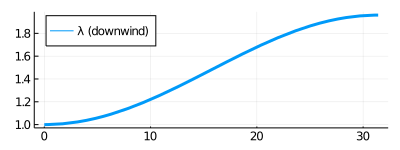

In [6]:
a = 1; h = 0.1; τ = 0.2 * h; μ = a * τ / h;  # experiment with smaller τ!
plot(x -> (1 + 4 * μ * (1+μ) * sin(h*x/2)^2), 0, pi/h, lw=3, label = "λ (downwind)", size = (400, 150), legend = :topleft)

Even if we start with a very smooth initial condition, numerical errors will quickly create high wave-number modes, and these will then be amplified causing the numerical stability we have observed.

For the upwind scheme we simply substitute $\mu \to -\mu$ and $h \to -h$ which yields  the amplification factor

$$ 
    \lambda(k) = 1 - 4 \mu(1-\mu) \sin^2(kh/2)
$$

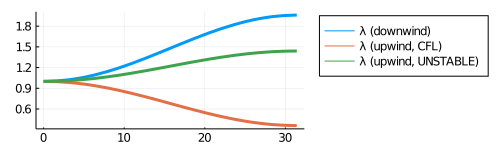

In [7]:
a = 1; h = 0.1; τ = 0.2 * h; μ = a * τ / h;  # experiment with larger τ!
plot(x -> (1 + 4 * μ * (1+μ) * sin(h*x/2)^2), 0, pi/h, lw=3, label = "λ (downwind)", size = (500, 150), legend = :outertopright)
plot!(x -> (1 - 4 * μ * (1-μ) * sin(h*x/2)^2), 0, pi/h, lw=3, label = "λ (upwind, CFL)")
plot!(x -> (1 + 4 * 1.1*0.1 * sin(h*x/2)^2), 0, pi/h, lw=3, label = "λ (upwind, UNSTABLE)")

and instead of blow-up we have artificial numerical damping of higher eigenmodes:
$$
    \| U^{m+1}\|^2 
    = h\int_{-\pi/h}^{\pi/h} |\hat{U}^{m+1}|^2 \,dk
    = h\int_{-\pi/h}^{\pi/h} |\lambda(k)|^2 |\hat{U}^m(k)|^2 \,dk.
$$

### Instability & Damping in Real Space

$$\begin{aligned}
    \| U^{m+1}\|^2 
    = h\int_{-\pi/h}^{\pi/h} |\hat{U}^{m+1}|^2 \,dk
    &= h\int_{-\pi/h}^{\pi/h} |\lambda(k)|^2 |\hat{U}^m(k)|^2 \,dk, \\
    \text{where} \qquad \lambda(k) &= 1 - 4 \mu(1-\mu) \sin^2(kh/2)
\end{aligned}$$

For many mathematicians (but maybe more so for physicists, engineers, ...) this is an extremely intuitive representation of what occurs in these schemes. But for others it would be nice to interpret this in real space. Such a real-space interpretation is also important if we want to add (non-PBC) boundary conditions since in that case we can no longer use Fourier analysis!

Key observation (see exercises): $4 \sin^2(kh/2)$ is the multiplier associated with the forward or backward finite difference:
$$
    h \int_{-\pi/h}^{\pi/h} 4 \sin^2(kh/2) |\hat{U}(k)|^2 \,dk 
    = \sum_{n \in \mathbb{Z}} | U_{n+1} - U_n |^2 =: \| D^\pm U \|^2.
$$

**Proposition:** Let $a > 0$ and $D^\pm$ the forward/backward difference operators, then 
* the upwind scheme satisfies
$$ 
    \|U^{m+1}\|^2 = \| U^m\|^2 - \mu(1-\mu) \|D^- U^m\|^2
$$
* while the downwind scheme satisfies 
$$ 
    \|U^{m+1}\|^2 = \| U^m\|^2 + \mu(1+\mu) \|D^+ U^m\|^2
$$

Thus, we see that the blow-up in the downwind scheme and the artificial numerical damping in the upwind scheme occurs precisely when there are large gradients.

┌ Info: Saved animation to 
│   fn = /Users/owensheekey/Documents/UBC/Math/Math 405/math405_2020W/notes/tmp.gif
└ @ Plots /Users/owensheekey/.julia/packages/Plots/shY1Z/src/animation.jl:104


Plots.AnimatedGif("/Users/owensheekey/Documents/UBC/Math/Math 405/math405_2020W/notes/tmp.gif")
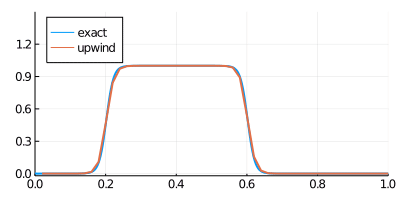

In [8]:
N = 50; h = 1/N; X = range(h, 1, length=N); xp = range(0, 1, length=1000)
Id = sparse(I, (N, N)); D⁻ = (Id - circshift(Id, 1)) / h
τ = 0.1 * h # let's be even more conservative than before!
u0 = x -> 1/(1+exp(-100 * (x - 0.2))) * 1/(1+exp(100 * (x - 0.6)))
# /u0 = x -> max(1 - 10*abs(x-0.5), 0)   #
U = u0.(X)
@gif for m = 1:150
    U -= τ * (D⁻ * U)
    plot(x -> u0(x-m*τ), 0, 1, lw=2, size = (400, 200), xlims = (0, 1), ylims = (-0.02, 1.5), label = "exact", legend = :topleft)
    plot!(X, U, lw=2, label = "upwind")
end

### Other schemes

* **Centered difference scheme:** 
$$
    \frac{U_{n}^{m+1} - U_n^m}{\tau} = - a \frac{U_{n+1}^m - U_{n-1}^m}{2 h}
$$
Incorporate both up and downwind. Idea is to get a stable scheme no matter which direction the advection. We will analyze this scheme in A4. (Spoiler: this is not a good idea.)

* **Lax-Wendroff scheme:** 
$$
    \frac{U_n^{m+1} - U_n^m}{\tau}
    = 
    - a \frac{U_{n+1}^m - U_{n-1}^m}{2 h}
    + \frac{\tau a^2}{2} \frac{U_{n+1}^m - 2 U_n^m + U_{n-1}^m}{h^2}
$$
Famous scheme for conservation laws, designed to overcome problems of centered differences. This is a group project.


### Outlook

We have now developed a first understanding of stability in FD schemes for advection problems. We have also seen a big challenge: numerical damping / diffusion.

Another related challenge is numerical dispersion and correctly capturing the group velocity! This is another group project!